## 4.3 状態空間モデル

In [50]:
%matplotlib inline

import collections

import arviz as az
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error
import seaborn as sns

sns.set()

### 4.3.1 モデル概要：ローカルレベルモデル

### 4.3.2 実装：ローカルレベルモデル

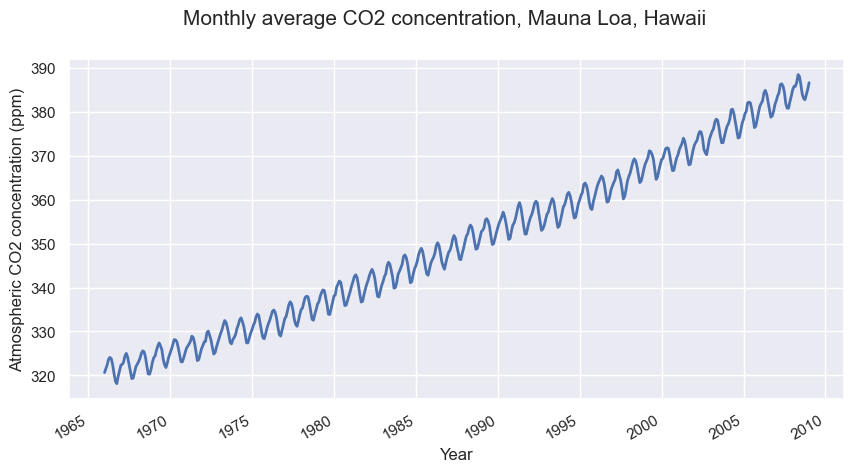

In [40]:
df = pd.read_csv("./../../data/monthly_in_situ_co2_mlo.csv")
df["date"] = pd.to_datetime(df["date"])
y = df["co2"].values
# dates = df["date"].values
# 書籍の著者が作成した描画関数を用いるために以下を使用した方が手っ取り早い.
dates = np.arange("1966-01", "2019-02", dtype="datetime64[M]")

num_forecast_steps = 12 * 10 # Forecast the final ten years, given previous data
y_train = y[:-num_forecast_steps]
y_test = y[-num_forecast_steps:]

x_loc = mdates.YearLocator(5)
x_fmt = mdates.DateFormatter('%Y')

fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(1, 1, 1)
ax.plot(dates[:-num_forecast_steps], y_train, lw=2, label="training data")
ax.xaxis.set_major_locator(x_loc)
ax.xaxis.set_major_formatter(x_fmt)
ax.set_ylabel("Atmospheric CO2 concentration (ppm)")
ax.set_xlabel("Year")
fig.suptitle("Monthly average CO2 concentration, Mauna Loa, Hawaii",
             fontsize=15)
fig.autofmt_xdate()
plt.show()

In [51]:
def plot_forecast(x, y,
                  forecast_mean, forecast_scale, forecast_samples,
                  x_locator=None, x_formatter=None):
  """Plot a forecast distribution against the 'true' time series."""
  colors = sns.color_palette()
  c1, c2 = colors[0], colors[1]
  fig = plt.figure(figsize=(10, 5))
  ax = fig.add_subplot(1, 1, 1)

  num_steps = len(y)
  num_steps_forecast = forecast_mean.shape[-1]
  num_steps_train = num_steps - num_steps_forecast

  ax.plot(x, y, lw=2, color=c1, label='ground truth')

  forecast_steps = np.arange(
      x[num_steps_train],
      x[num_steps_train]+num_steps_forecast,
      dtype=x.dtype)

  ax.plot(forecast_steps, forecast_samples.T, lw=1, color=c2, alpha=0.1)

  ax.plot(forecast_steps, forecast_mean, lw=2, ls='--', color=c2,
           label='forecast')
  ax.fill_between(forecast_steps,
                   forecast_mean-2*forecast_scale,
                   forecast_mean+2*forecast_scale, color=c2, alpha=0.2)

  ymin, ymax = min(np.min(forecast_samples), np.min(y)), max(np.max(forecast_samples), np.max(y))
  yrange = ymax-ymin
  ax.set_ylim([ymin - yrange*0.1, ymax + yrange*0.1])
  ax.set_xlabel('Year')
  ax.set_ylabel('y')
  ax.legend()

  if x_locator is not None:
    ax.xaxis.set_major_locator(x_locator)
    ax.xaxis.set_major_formatter(x_formatter)
    fig.autofmt_xdate()

  return fig, ax


def plot_components(dates,
                    component_means_dict,
                    component_stddevs_dict,
                    x_locator=None,
                    x_formatter=None):
  """Plot the contributions of posterior components in a single figure."""
  colors = sns.color_palette()
  c1, c2 = colors[0], colors[1]

  axes_dict = collections.OrderedDict()
  num_components = len(component_means_dict)
  fig = plt.figure(figsize=(10, 3 * num_components))
  for i, component_name in enumerate(component_means_dict.keys()):
    component_mean = component_means_dict[component_name]
    component_stddev = component_stddevs_dict[component_name]

    ax = fig.add_subplot(num_components,1,1+i)
    ax.plot(dates, component_mean, lw=2)
    ax.fill_between(dates,
                     component_mean-2*component_stddev,
                     component_mean+2*component_stddev,
                     color=c2, alpha=0.5)
    ax.set_title(component_name)
    if x_locator is not None:
      ax.xaxis.set_major_locator(x_locator)
      ax.xaxis.set_major_formatter(x_formatter)
    axes_dict[component_name] = ax
  ax.set_xlabel('Year')
  fig.autofmt_xdate()
  fig.tight_layout()
  return fig, axes_dict

In [26]:
import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow_probability import sts

tfd = tfp.distributions

In [27]:
def build_llevel_model(observed_time_series):
    """ローカルレベルモデルの定義."""
    # 状態成分
    level = sts.LocalLevel(observed_time_series=observed_time_series)
    # 各状態成分と観測誤差を加算
    model = sts.Sum([level], observed_time_series=observed_time_series)
    return model


def variational_inference(model, observed_time_series, num_variational_steps):
    """変分推論法"""
    variational_posteriors = sts.build_factored_surrogate_posterior(model)
    optimizer = tf.optimizers.Adam(learning_rate=0.10)

    # ELBO loss (ELBO の負値) の最小化
    @tf.function(experimental_compile=True)
    def train():
        elbo_loss_curve = tfp.vi.fit_surrogate_posterior(
            target_log_prob_fn=model.joint_log_prob(
                observed_time_series=observed_time_series
            ),
            surrogate_posterior=variational_posteriors,
            optimizer=optimizer,
            num_steps=num_variational_steps
        )
        return elbo_loss_curve

    elbo_loss_curve = train()

    # ELBO の推移を描画
    plt.plot(elbo_loss_curve)
    plt.xlabel("step")
    plt.ylabel("negative ELBO")
    plt.show()

    return variational_posteriors

Instructions for updating:
Please use `StructuralTimeSeries.joint_distribution(observed_time_series).log_prob`


Instructions for updating:
Please use `StructuralTimeSeries.joint_distribution(observed_time_series).log_prob`


Instructions for updating:
`scale_identity_multiplier` is deprecated; please combine it into `scale_diag` directly instead.


Instructions for updating:
`scale_identity_multiplier` is deprecated; please combine it into `scale_diag` directly instead.
2022-09-27 07:27:40.355166: W tensorflow/compiler/tf2xla/kernels/random_ops.cc:102] Warning: Using tf.random.uniform with XLA compilation will ignore seeds; consider using tf.random.stateless_uniform instead if reproducible behavior is desired. fit_surrogate_posterior/StatefulPartitionedCall/monte_carlo_variational_loss/default_joint_bijectorJointDistributionNamedAutoBatched_CONSTRUCTED_AT_monte_carlo_variational_loss_build_factored_surrogate_posterior_1/sample_and_log_prob/JointDistributionNamedAutoBatched/sample_and_log_prob/sanitize_seed/seed


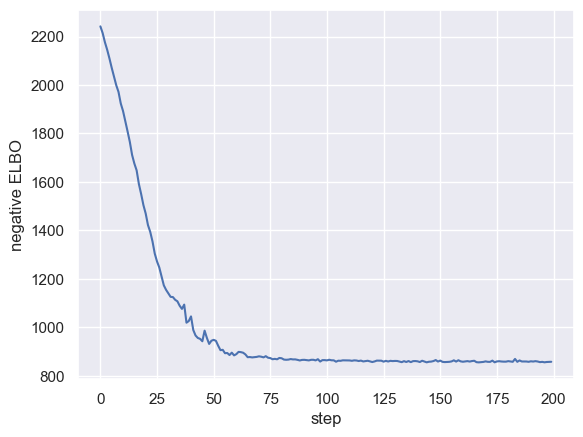

In [28]:
llevel_model = build_llevel_model(y_train)

num_variational_steps = 200
variational_posteriors = variational_inference(llevel_model, y_train, num_variational_steps)

In [29]:
# 近似事後分布からのサンプルを取得.
q_samples = variational_posteriors.sample(50)

print("Inferred parameters:")
for param in llevel_model.parameters:
    msg = "{0}: {1:.3g} ± {2:.3g}"
    print(msg.format(param.name, np.mean(q_samples[param.name], axis=0), np.std(q_samples[param.name], axis=0)))

Inferred parameters:
observation_noise_scale: 0.0936 ± 0.0195
LocalLevel/_level_scale: 1.21 ± 0.0427


(<Figure size 1000x500 with 1 Axes>, <AxesSubplot:xlabel='Year', ylabel='y'>)

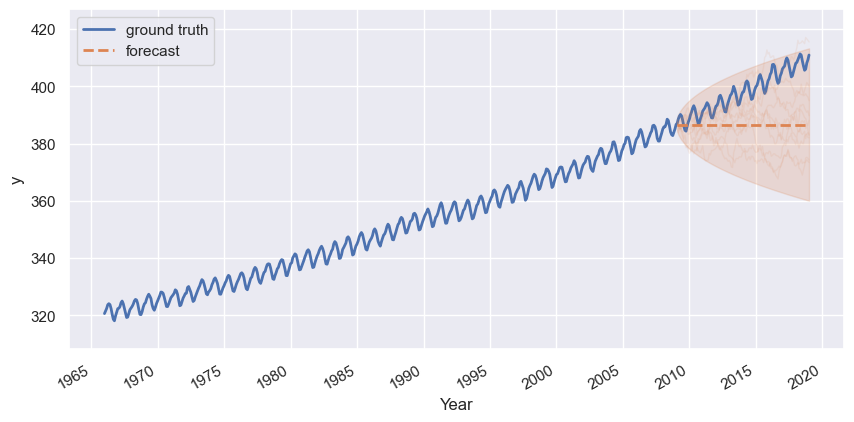

In [41]:
# パラメータの事後分布からのサンプルを用いて, 未来の観測値の予測分布を算出する.
# tfd.MixtureSameFamily が返される. 混合要素数は事後分布からのサンプルサイズとなる.
pred_dist = sts.forecast(
    model=llevel_model,
    observed_time_series=y_train,
    parameter_samples=q_samples,
    num_steps_forecast=num_forecast_steps
)

# 予測分布の平均, 標準偏差を算出, 予測分布からのサンプルも取得
num_samples = 10
pred_mean, pred_scale, pred_samples = (
    pred_dist.mean().numpy()[..., 0],
    pred_dist.stddev().numpy()[..., 0],
    pred_dist.sample(num_samples).numpy()[..., 0],
)

plot_forecast(dates, y, pred_mean, pred_scale, pred_samples, x_loc, x_fmt)

In [43]:
print("MAE (local level model): {:.1f}".format(mean_absolute_error(pred_mean, y_test)))

MAE (local level model): 11.5


### 4.3.3 構造時系列モデル

### 4.3.4 モデル概要：トレンド成分

### 4.3.5 モデル概要：季節成分

### 4.3.6 実装：構造時系列モデル

In [44]:
def build_trend_seasonal_model(observed_time_series):
    # トレンド成分
    trend = sts.LocalLinearTrend(observed_time_series=observed_time_series)

    # 季節成分 (12ヶ月周期)
    seasonal = tfp.sts.Seasonal(
        num_seasons=12, observed_time_series=observed_time_series
    )

    # 各成分を足し合わせる
    model = sts.Sum([trend, seasonal], observed_time_series=observed_time_series)

    return model

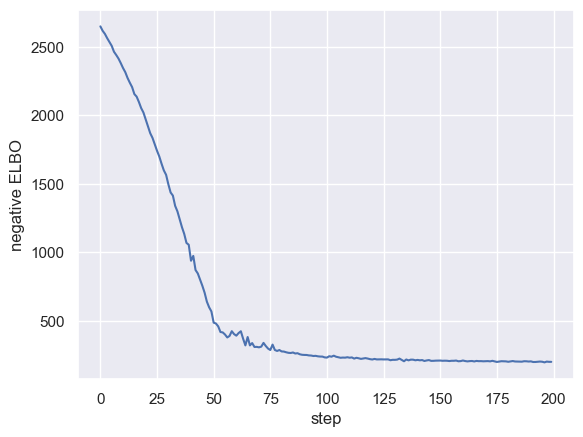

Inferred parameters:
observation_noise_scale: 0.16 ± 0.00856
LocalLinearTrend/_level_scale: 0.166 ± 0.012
LocalLinearTrend/_slope_scale: 0.0158 ± 0.00163
Seasonal/_drift_scale: 0.0379 ± 0.00781


In [46]:
trend_seasonal_model = build_trend_seasonal_model(y_train)

num_variational_steps = 200
variational_posteriors = variational_inference(
    trend_seasonal_model,
    y_train,
    num_variational_steps
)

# 近似事後分布からのサンプルを取得
q_samples = variational_posteriors.sample(50)

print("Inferred parameters:")
for param in trend_seasonal_model.parameters:
    msg = "{0}: {1:.3g} ± {2:.3g}"
    print(msg.format(param.name, np.mean(q_samples[param.name], axis=0), np.std(q_samples[param.name], axis=0)))

MAE (local level model): 2.6


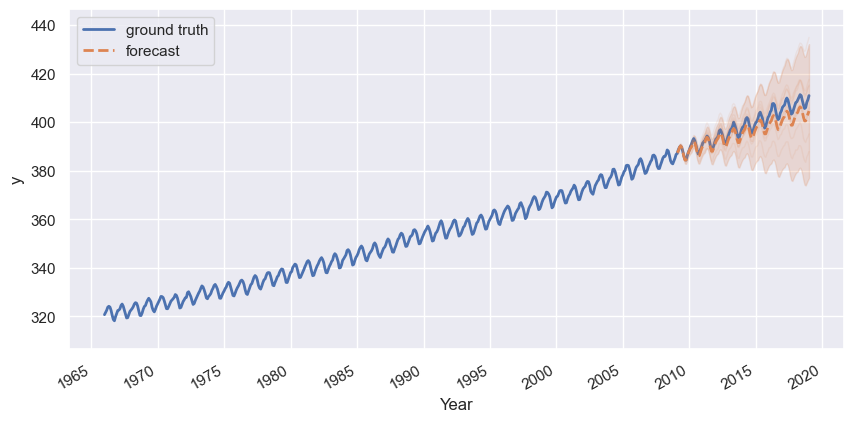

In [49]:
# パラメータの事後分布からのサンプルを用いて, 未来の観測値の予測分布を算出する.
# tfd.MixtureSameFamily が返される. 混合要素数は事後分布からのサンプルサイズとなる.
pred_dist = sts.forecast(
    model=trend_seasonal_model,
    observed_time_series=y_train,
    parameter_samples=q_samples,
    num_steps_forecast=num_forecast_steps
)

# 予測分布の平均, 標準偏差を算出, 予測分布からのサンプルも取得
num_samples = 10
pred_mean, pred_scale, pred_samples = (
    pred_dist.mean().numpy()[..., 0],
    pred_dist.stddev().numpy()[..., 0],
    pred_dist.sample(num_samples).numpy()[..., 0],
)

plot_forecast(dates, y, pred_mean, pred_scale, pred_samples, x_loc, x_fmt)
print("MAE (local level model): {:.1f}".format(mean_absolute_error(pred_mean, y_test)))

(<Figure size 1000x600 with 2 Axes>,
 OrderedDict([('LocalLinearTrend/',
               <AxesSubplot:title={'center':'LocalLinearTrend/'}>),
              ('Seasonal/',
               <AxesSubplot:title={'center':'Seasonal/'}, xlabel='Year'>)]))

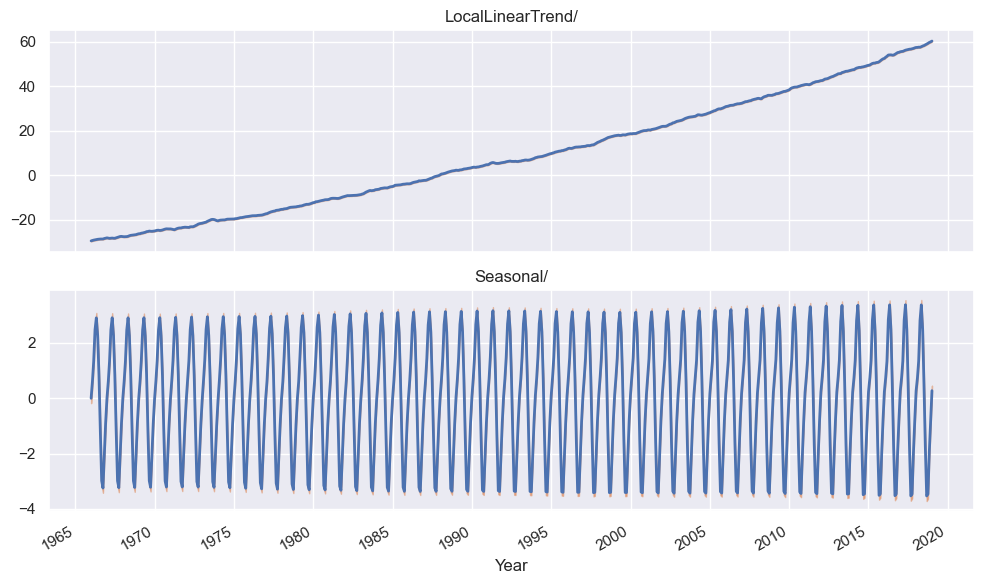

In [52]:
# 状態成分ごとの事後分布を算出し, 各成分を表す StructuralTimeSeries インスタンスを key,
# 事後分布を表す tfp.Distribution インスタンスを value とする OrderedDict を返す.
component_dists = sts.decompose_by_component(
    trend_seasonal_model,
    observed_time_series=y,
    parameter_samples=q_samples
)

# 各成分の事後分布の平均と標準偏差を算出
component_means, component_stddevs = (
    {k.name: c.mean() for k, c in component_dists.items()},
    {k.name: c.stddev() for k, c in component_dists.items()}
)

# 成分ごとのプロット
plot_components(dates, component_means, component_stddevs, x_locator=x_loc, x_formatter=x_fmt)